# Imports

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import time
from datetime import timedelta
import math

In [2]:
tf.__version__

'2.3.1'

# Load Data

In [3]:
from tensorflow.keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [4]:
print("Size of:")
print(" - Training-set:\t\t{}".format(len(x_train)))
print(" - Test-set:\t\t\t{}".format(len(x_test)))

Size of:
 - Training-set:		60000
 - Test-set:			10000


In [5]:
x_train.shape

(60000, 28, 28)

# Helper function for plotting the images

In [7]:
def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape(img_shape), cmap='binary')

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

# Data Dimensions

In [8]:
# We know that MNIST images are 28 pixels by 28 pixels
img_size = 28

# Images are stored in one-dimensional arrays of this length - number of numbers in the matrix of size 28 x 28
img_size_flat = img_size*img_size

# Height and width of each image in Tuple
img_shape = (img_size, img_size)

# Number of color channels for the image: 1 channel for gray-scale
num_channels = 1

# Number of classes, one class for each of 10 digits
num_classes = 10

# Visualise Data

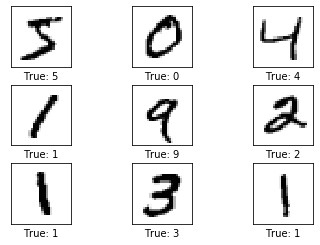

In [9]:
# Get the first images from the train set.
images = x_train[0:9]

# Get the true classes for those images.
cls_true = y_train[0:9]

# Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true)

# Hyperparameters of the Neural Network

In [10]:
# Convolutional layer 1
filter1_size = 5  #Convolution filters are 5 x 5 pixels
num_filters1 = 16 #There are 16 of these filters

# Convolutional layer 2
filter2_size = 5 #Convolution filters are 5 x 5 pixels
num_filters2 = 32 #There are 32 of these filters

# Pooling
window_size = 2 #Pooling window 2x2
window_stride = 2 #Move by 2 strides

# Fully-connected layer
fc_size=128     # Number of nodes in the fully-connected layer

# Transform the input data into the required shape/format

In [11]:
x_train.shape

(60000, 28, 28)

In [13]:
x_train[:100].shape

(100, 28, 28)

In [123]:
# Prepare the input data
x = tf.constant(x_train[:100], tf.float32)
y = tf.constant(y_train[:100], tf.int64)

In [124]:
x.shape, y.shape

(TensorShape([100, 28, 28]), TensorShape([100]))

In [125]:
# Reshape as required for ConvNet
x_image = tf.reshape(x, [-1, img_size, img_size, num_channels])

In [126]:
x_image.shape

TensorShape([100, 28, 28, 1])

## Helper function for Convolutional Layer

In [18]:
def conv_layer(inputs, filter_size, num_channels, num_filters, img_size, conv_stride, pooling_window_size, pooling_window_stride):
    # Define shape for weights
    shape_weights = [filter_size, filter_size, num_channels, num_filters]
    # Define weights
    weights = tf.Variable(tf.random.normal(shape=shape_weights, stddev=0.05))
    # Define shape for Bias
    shape_bias = [1, img_size, img_size, num_filters]
    # Define Bias
    bias = tf.Variable(tf.ones(shape=shape_bias))
    # Define convolutional layer
    conv = tf.nn.conv2d(input=inputs, filters=weights, strides=conv_stride, padding='SAME')
    # Add bias
    conv+=bias
    # Apply RELU activation function
    conv = tf.nn.relu(conv)
    # Apply Max Pooling
    conv = tf.nn.max_pool(input=conv, ksize=pooling_window_size, strides=pooling_window_stride, padding='SAME')
    return conv, weights

In [19]:
# Calculate 1st convolutional layer
conv1, weights1 = conv_layer(x_image, filter1_size, 1, num_filters1, img_size, 1, window_size, window_stride)

In [20]:
conv1.shape

TensorShape([100, 14, 14, 16])

In [21]:
weights1.shape

TensorShape([5, 5, 1, 16])

In [22]:
# Calculate 2nd convolutional layer
conv2, weights2 = conv_layer(conv1, filter2_size, num_filters1, num_filters2, conv1.shape[1], 1, window_size, window_stride)

In [23]:
conv2.shape

TensorShape([100, 7, 7, 32])

In [24]:
weights2.shape

TensorShape([5, 5, 16, 32])

## Helper-function for flattening a layer

In [143]:
def flatten_layer(layer):
    # Get the shape of the layer
    layer_shape = layer.get_shape()
    # Calculate the number of features which is: img_height * img_width * num_channels
    num_features = layer_shape[1:4].num_elements()
    # Reshape the layer to [num_images, num_features].
    # Note that we just set the size of the second dimension
    # to num_features and the size of the first dimension to -1
    # which means the size in that dimension is calculated
    # so the total size of the tensor is unchanged from the reshaping.
    flat_layer = tf.reshape(layer, [-1, num_features])
    return flat_layer, num_features

## Helper-function for the fully connected layer

In [44]:
# Define the architecture of the fully connected network
def fc_layer(inputs, num_features, fc_size):
    # Define the weights
    weights = tf.Variable(tf.random.normal(shape=[num_features, fc_size]))
    # Matrix multiply the input and the weights
    layer_product = tf.matmul(inputs, weights)
    # Initialize the layer bias: one bias for each node
    bias = tf.Variable(tf.ones([fc_size]))
    # Construct the fully connected layer
    layer = tf.nn.relu(layer_product+bias)
    return layer, weights

## Helper-function for the output layer

In [48]:
def out_layer(inputs, num_feature, num_nodes):
    # Define weights
    weights = tf.Variable(tf.random.normal(shape=[num_feature, num_nodes]))
    # Matrix multiply the input and the weights
    layer_product = tf.matmul(inputs, weights)
    # Initialize the layer bias
    bias = tf.Variable(tf.ones([num_nodes]))
    # Construct the output layer
    layer = tf.nn.softmax(layer_product+bias)
    return layer, weights

In [144]:
# Flatten the output of 2nd convolutional layer 
flat_layer, num_features = flatten_layer(conv2)

In [147]:
flat_layer.shape

TensorShape([100, 1568])

In [148]:
num_features

1568

In [150]:
# Define the weights for fully connected layer
w1 = tf.Variable(tf.random.normal(shape=[num_features, fc_size]))
# Initialize the bias for fully connected layer
b1 = tf.Variable(tf.ones([fc_size]))
# Define weights for the output layer
w_o = tf.Variable(tf.random.normal(shape=[fc_size, num_classes]))
# Initialize the layer bias
b_o = tf.Variable(tf.ones([num_classes]))

In [152]:
# Define the architecture of the network and the model
def nn_forward(inputs, w1, b1, w_o, b_o):
    fc_product = tf.matmul(inputs, w1)
    fully_connected = tf.keras.activations.relu(fc_product+b1)
    output_product = tf.matmul(fully_connected, w_o)
    output = tf.keras.activations.softmax(output_product+b_o)
    return output

## Helper-function for the loss function

In [155]:
def nn_loss_function(inputs, w1, b1, w_o, b_o, actual):
    prediction = nn_forward(inputs, w1, b1, w_o, b_o)
    y_pred_cls = tf.argmax(prediction, axis=1)
    loss = tf.keras.losses.categorical_crossentropy(actual, y_pred_cls)
    return loss

## Train the model

In [156]:
# Train the model by learning the optimal weights

opt = tf.keras.optimizers.Adam(0.5) # 1.Initialize optimizer with learning rate of 0.5

for j in range(100): # 2. Search for the optimal values for the weights
    opt.minimize(lambda: nn_loss_function(flat_layer, w1, b1, w_o, b_o, y), var_list=[w1, b1, w_o, b_o]) 

InvalidArgumentError: cannot compute Mul as input #1(zero-based) was expected to be a int64 tensor but is a double tensor [Op:Mul]